In [1]:
import pandas as pd

### import extra package
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#### modelling package
from statsmodels.graphics.mosaicplot import mosaic
import statsmodels
from statsmodels.formula.api import logit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split


#### importing evaluation package 
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, auc,\
precision_recall_curve, roc_curve, average_precision_score
from sklearn import metrics

### Helper functions

In [2]:
def evaluation(y_true, y_pred, title = ""):
    """
    This function is used to compute the confusion matrix 
    and other evaluation metrics.
    """
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix for {}: \n'.format(title), cm)
    total = sum(sum(cm))
    
    print('=============')
    accuracy = (cm[0,0] + cm[1,1]) /total
    print ('Accuracy    : {}'.format(accuracy))
    Specificity = cm[0,0] / (cm[0,0] + cm[0,1])
    print('Specificity :  {}'.format(Specificity))
    sensitivity = cm[1,1] / (cm[1,0] + cm[1,1])
    print('Sensitivity :  {}'.format(sensitivity))
    
    
def plot_swarm(x, y, df):
    sns.set()
    sns.swarmplot(x=x, y = y, data = df)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.show()
    
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

### Global parameter 

In [3]:
look_back_days = 7

## 1. Data Preparation 

In [4]:
### load data 
user_df = pd.read_csv("users.csv")
sessions_df = pd.read_csv("sessions.csv").drop_duplicates()
iaps_df = pd.read_csv("iaps.csv").drop_duplicates()
spending_df = pd.read_csv("spendevents.csv").drop_duplicates()

### change to datetime format
spending_df["date"] = pd.to_datetime(spending_df["date"])
sessions_df["date"] = pd.to_datetime(sessions_df["date"])
user_df["install_date"] = pd.to_datetime(user_df["install_date"])
iaps_df["date"] = pd.to_datetime(iaps_df["date"])

In [5]:
sessions_df = pd.merge(sessions_df, user_df[["user_id", "install_date"]], on = "user_id")
spending_df = pd.merge(spending_df, user_df[["user_id", "install_date"]], on = "user_id")

In [6]:
spending_df.head()

,user_id,ts,date,story,chapter,spendtype,currency,amount,install_date
0,9829,2019-03-01 03:03:04,2019-03-01,story_1,0,earnGemsCounter,gems,-22,2019-03-01
1,13757,2019-03-01 03:35:53,2019-03-01,story_1,0,earnGemsCounter,gems,-22,2019-03-01
2,13757,2019-03-01 03:52:10,2019-03-01,story_2,0,earnGemsCounter,gems,-22,2019-03-01
3,13757,2019-04-16 04:29:18,2019-04-16,story_1,9,premiumChoice,gems,24,2019-03-01
4,13757,2019-04-17 04:41:31,2019-04-17,story_2,2,earnGemsCounter,gems,-10,2019-03-01


In [7]:
def add_num_active_days_column(df):
    df["days_from_installed"] = df["date"] - df["install_date"]
    df["days_from_installed"] = df["days_from_installed"].dt.days
    idx = df.groupby("user_id")["days_from_installed"].transform(max)\
        == df["days_from_installed"]
    num_days_active_sessions = df[idx][["user_id", "days_from_installed"]]\
                                .drop_duplicates().rename(columns={"days_from_installed": "active_days_sessions"})
    df = pd.merge(df, num_days_active_sessions, on = "user_id")
    return df
sessions_df = add_num_active_days_column(sessions_df)
spending_df = add_num_active_days_column(spending_df)

In [8]:
def add_last_active_date_column(sessions, spending):
    idx = sessions.groupby("user_id")["ts"].transform(max) == sessions["ts"]
    last_day_session = sessions[idx][["user_id", "ts"]].rename(columns={"ts": "last_active_date"})
    sessions = pd.merge(sessions, last_day_session, on = "user_id")
    spending = pd.merge(spending, last_day_session, on = "user_id")
    
    return sessions, spending
sessions_df, spending_df = add_last_active_date_column(sessions_df, spending_df)

In [9]:
sessions_df.head()

,user_id,ts,date,session_num,last_session_termination_type,install_date,days_from_installed,active_days_sessions,last_active_date
0,14067,2019-03-01 00:06:50,2019-03-01,1,NaN,2019-03-01,0,22,2019-03-23 22:57:59
1,14067,2019-03-01 00:22:27,2019-03-01,2,NaN,2019-03-01,0,22,2019-03-23 22:57:59
2,14067,2019-03-01 09:42:32,2019-03-01,3,NaN,2019-03-01,0,22,2019-03-23 22:57:59
3,14067,2019-03-01 09:43:33,2019-03-01,4,NaN,2019-03-01,0,22,2019-03-23 22:57:59
4,14067,2019-03-01 09:55:33,2019-03-01,5,NaN,2019-03-01,0,22,2019-03-23 22:57:59


### extract paying users and their info

In [10]:
users_iaps = pd.merge(user_df, iaps_df, on = "user_id")
users_iaps["days_to_first_purchase"] = users_iaps["date"] - users_iaps["install_date"]
users_iaps["days_to_first_purchase"] = users_iaps["days_to_first_purchase"].dt.days
users_iaps["rank"] = users_iaps.groupby(["user_id"])["days_to_first_purchase"].rank(method="first", ascending=True)
users_iaps["rank"] = users_iaps["rank"].astype(int)
paying_users_df = users_iaps[users_iaps["rank"]==1]
first_iap_day_df = paying_users_df[["user_id", "ts", "days_to_first_purchase",\
                                    "install_date"]].rename(columns={"ts": "iap_date"}) #### 1526 paying users
first_iap_day_df.head()

,user_id,iap_date,days_to_first_purchase,install_date
0,2,2019-03-07 11:50:37,1,2019-03-06
1,21,2019-03-09 10:18:32,2,2019-03-07
4,36,2019-03-02 23:34:17,0,2019-03-02
10,51,2019-03-02 21:19:39,0,2019-03-02
20,85,2019-04-17 18:26:44,41,2019-03-07


In [11]:
earnGemsCounter_df = spending_df[spending_df.spendtype=='earnGemsCounter']
premiumChoice_df = spending_df[spending_df.spendtype=='premiumChoice']
IAP_df = spending_df[spending_df.spendtype=='IAP']

### extract non-paying users 
- Remove non-active players (those are not active within 7 days)
- All users who haven’t converted after 45 days and still active will be labeled as 0.
- In the label 0 group of 2463 non-paying users, 186 of them don't have record in spendevents. We will exclude them 

In [12]:
non_payer_df = user_df[~user_df.user_id.isin(iaps_df["user_id"].unique())]
non_payer_df.head(2)

,user_id,install_date,lang,country,hw_ver,os_ver
0,0,2019-03-01,en,US,"iPhone4,1",9.1
1,1,2019-03-01,en,IN,"iPod5,1",8.1.2


In [13]:
non_payer_df = user_df[~user_df.user_id.isin(iaps_df["user_id"].unique())][["user_id"]] ## total of 21050 non-paying users
session_non_payer_df = pd.merge(non_payer_df[["user_id"]], sessions_df, on = "user_id")
session_non_payer_df.head(2) #### 21018 unique users

,user_id,ts,date,session_num,last_session_termination_type,install_date,days_from_installed,active_days_sessions,last_active_date
0,0,2019-03-01 12:39:19,2019-03-01,1,NaN,2019-03-01,0,4,2019-03-05 05:39:29
1,0,2019-03-01 12:45:47,2019-03-01,2,NaN,2019-03-01,0,4,2019-03-05 05:39:29


In [14]:
session_non_payer_df["most_recent_date"] = pd.to_datetime('2019-05-06')
session_non_payer_df["days_to_most_recent"] = session_non_payer_df["most_recent_date"] - session_non_payer_df["date"]
session_non_payer_df["days_to_most_recent"] = session_non_payer_df["days_to_most_recent"].dt.days
session_non_payer_df.head(2)

,user_id,ts,date,session_num,last_session_termination_type,install_date,days_from_installed,active_days_sessions,last_active_date,most_recent_date,days_to_most_recent
0,0,2019-03-01 12:39:19,2019-03-01,1,NaN,2019-03-01,0,4,2019-03-05 05:39:29,2019-05-06,66
1,0,2019-03-01 12:45:47,2019-03-01,2,NaN,2019-03-01,0,4,2019-03-05 05:39:29,2019-05-06,66


## 2. Extract Potential Users for promotion and their characteristics

In [15]:
NPU_active_users = session_non_payer_df[session_non_payer_df["days_to_most_recent"] <= 10]
NPU_active_users = NPU_active_users[["user_id", "install_date"]].drop_duplicates()
NPU_active_users.head(2) ### 1733 users

,user_id,install_date
285,10,2019-03-05
337,11,2019-03-04


In [16]:
### characteristics of churning users 
NPU_active_users_spending = pd.merge(NPU_active_users, spending_df, on="user_id")
NPU_active_users_spending.head(2) ### 1608 users

NPU_active_users_sessions = pd.merge(NPU_active_users, sessions_df, on="user_id")
NPU_active_users_sessions.head(2) ### 1401 users

,user_id,install_date_x,ts,date,session_num,last_session_termination_type,install_date_y,days_from_installed,active_days_sessions,last_active_date
0,10,2019-03-05,2019-03-05 05:56:59,2019-03-05,1,NaN,2019-03-05,0,60,2019-05-04 23:16:31
1,10,2019-03-05,2019-03-05 05:58:30,2019-03-05,2,NaN,2019-03-05,0,60,2019-05-04 23:16:31


In [17]:
NPU_active_users_sessions["n_days_before_last_date"] = pd.to_datetime(NPU_active_users_sessions["last_active_date"]) \
                                                                    - pd.Timedelta(days=look_back_days)
NPU_active_users_sessions_ft = NPU_active_users_sessions[(NPU_active_users_sessions.ts\
                                                       >= NPU_active_users_sessions.n_days_before_last_date) \
                                                      & (NPU_active_users_sessions.ts <= NPU_active_users_sessions.last_active_date)]

NPU_active_users_spending["n_days_before_last_date"] = \
                                pd.to_datetime(NPU_active_users_spending["last_active_date"]) - pd.Timedelta(days=look_back_days)
NPU_active_users_spending_ft = NPU_active_users_spending[(NPU_active_users_spending.ts\
                                                       >= NPU_active_users_spending.n_days_before_last_date) \
                                                      & (NPU_active_users_spending.ts <= NPU_active_users_spending.last_active_date)]

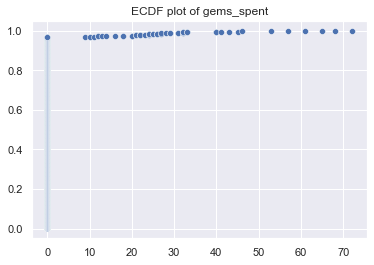

In [18]:
def plot_ecdf(series, title=""):
    """
    series = df_eargems_sum["gems_spent"]
    """
    sns.set()
    x_ecdf, y_ecdf = ecdf(series)
    sns.scatterplot(x=x_ecdf, y=y_ecdf)
    plt.title(title)
    
def spent_gems_rate(df_user):
    df_eargems = df_user[df_user.spendtype == 'premiumChoice']
    df_eargems_sum = df_eargems.groupby("user_id")['amount'].sum().reset_index()
    df_eargems_sum = pd.merge(df_eargems_sum, sessions_df[["user_id",\
                                                           "active_days_sessions"]].drop_duplicates(), on = "user_id")
    df_eargems_sum["gems_spent"] = df_eargems_sum["amount"]
    df_eargems_sum = df_eargems_sum[df_eargems_sum.user_id != 12486] 
    return df_eargems_sum[["user_id","gems_spent"]]

potentialUser_spent_gems = spent_gems_rate(NPU_active_users_spending_ft)
potentialUser_spent_gems = pd.merge(NPU_active_users[["user_id"]].drop_duplicates(),\
                                    potentialUser_spent_gems, how='left', on ="user_id").fillna(0)
plot_ecdf(potentialUser_spent_gems["gems_spent"], "ECDF plot of gems_spent")

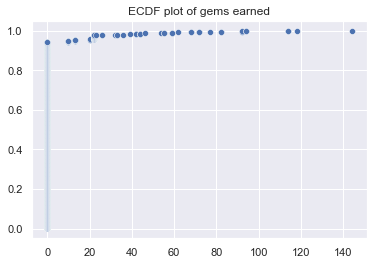

In [19]:
def earn_gems_rate(df_user):
    df_eargems = df_user[df_user.spendtype == 'earnGemsCounter']
    df_eargems_sum = df_eargems.groupby("user_id")['amount'].sum().reset_index()
    df_eargems_sum = pd.merge(df_eargems_sum, sessions_df[["user_id",\
                                                           "active_days_sessions"]].drop_duplicates(), on = "user_id")
    df_eargems_sum["gems_earn"] = df_eargems_sum["amount"]*(-1)
    df_eargems_sum = df_eargems_sum[df_eargems_sum.user_id != 12486]
    
    return df_eargems_sum[["user_id","gems_earn"]]
potentialUser_earn_gems = earn_gems_rate(NPU_active_users_spending_ft)
potentialUser_earn_gems = pd.merge(NPU_active_users[["user_id"]].drop_duplicates(),\
                                    potentialUser_earn_gems, how='left', on ="user_id").fillna(0)
plot_ecdf(potentialUser_earn_gems["gems_earn"], "ECDF plot of gems earned")

In [20]:
NPU_active_users_sessions["user_id"].nunique()

1733

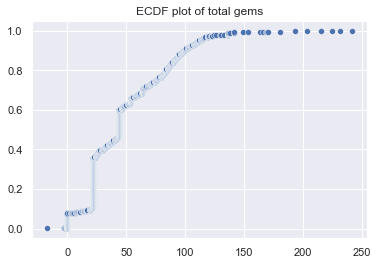

In [21]:
def total_gems_left(df_user):
    df_eargems_sum = df_user.groupby("user_id")['amount'].sum().reset_index().rename(columns={'amount': 'gems_amount'})
    df_eargems_sum = pd.merge(df_eargems_sum, sessions_df[["user_id",\
                                                           "active_days_sessions"]].drop_duplicates(), on = "user_id")
    df_eargems_sum["total_gems"] = df_eargems_sum["gems_amount"]*(-1)
    df_eargems_sum = df_eargems_sum[df_eargems_sum.user_id != 12486]
    return df_eargems_sum[["user_id", "total_gems"]]

potentialUser_total_gems = total_gems_left(NPU_active_users_spending)  
potentialUser_total_gems = pd.merge(NPU_active_users[["user_id"]].drop_duplicates(),\
                                    potentialUser_total_gems, how='left', on ="user_id").fillna(0)
plot_ecdf(potentialUser_total_gems["total_gems"], "ECDF plot of total gems")

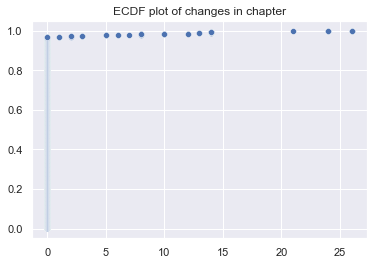

In [22]:
def change_in_chapter(df):
    idx = df.groupby("user_id")["chapter"].transform(max) == df["chapter"]
    max_chapter = df[idx]
    max_chapter = max_chapter[["user_id", "chapter"]].drop_duplicates().rename(columns={"chapter": "max_chapter"})
    
    idx = df.groupby("user_id")["chapter"].transform(min) == df["chapter"]
    min_chapter = df[idx]
    min_chapter = min_chapter[["user_id", "chapter"]].drop_duplicates().rename(columns={"chapter": "min_chapter"})
    
    df_join = pd.merge(max_chapter, min_chapter, on = "user_id")
    df_join["chapter_changes"] = df_join["max_chapter"] - df_join["min_chapter"]
    
    return df_join[["user_id","chapter_changes"]]

potentialUser_chapter_change = change_in_chapter(NPU_active_users_spending_ft)  
potentialUser_chapter_change = pd.merge(NPU_active_users[["user_id"]].drop_duplicates(),\
                                    potentialUser_chapter_change, how='left', on ="user_id").fillna(0)
plot_ecdf(potentialUser_chapter_change["chapter_changes"], "ECDF plot of changes in chapter")

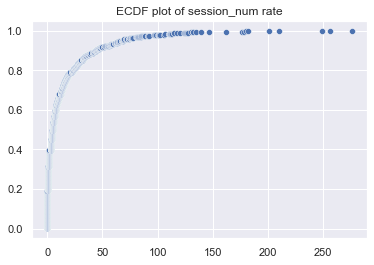

In [23]:
def sessions_num_rate(df_user):
    idx = df_user.groupby("user_id")["session_num"].transform(max) == df_user["session_num"]
    session_max = df_user[idx]
    session_max = session_max[["user_id", "session_num"]].drop_duplicates().rename(columns = {"session_num": "max_session"})
   
    idx = df_user.groupby("user_id")["session_num"].transform(min) == df_user["session_num"]
    session_min = df_user[idx]
    session_min = session_min[["user_id", "session_num"]].drop_duplicates().rename(columns = {"session_num": "min_session"})
    
    df_join = pd.merge(session_max, session_min, on="user_id")
    df_join["changes_session"] = df_join["max_session"] - df_join["min_session"]
    
    return df_join[["user_id","changes_session"]]
 

potentialUser_session_change = sessions_num_rate(NPU_active_users_sessions_ft)   
potentialUser_session_change = pd.merge(NPU_active_users[["user_id"]].drop_duplicates(),\
                                    potentialUser_session_change, how='left', on ="user_id").fillna(0)
plot_ecdf(potentialUser_session_change["changes_session"], "ECDF plot of session_num rate")

## 3. Extract label 0 class and their characteristics
- churn users

In [24]:
label0_users_df = session_non_payer_df[(session_non_payer_df["days_to_most_recent"] <= 25)\
                                        & ((session_non_payer_df["days_to_most_recent"] > 10))]
label0_users_df = label0_users_df[["user_id", "install_date"]].drop_duplicates()
label0_users_df = label0_users_df[~label0_users_df["user_id"].isin(set(NPU_active_users["user_id"]))]
label0_users_df.head(2)

,user_id,install_date
1870,76,2019-03-01
1900,81,2019-03-04


In [25]:
label0_users_spending = pd.merge(label0_users_df, spending_df, on="user_id")
label0_users_spending["user_id"].nunique()

1386

In [26]:
label0_users_sessions = pd.merge(label0_users_df, sessions_df, on="user_id")
label0_users_sessions["user_id"].nunique()

1518

In [27]:
label0_users_sessions["n_days_before_iap"] = pd.to_datetime(label0_users_sessions["last_active_date"]) \
                                                                    - pd.Timedelta(days=look_back_days)
label0_users_sessions_ft = label0_users_sessions[(label0_users_sessions.ts\
                                                       >= label0_users_sessions.n_days_before_iap) \
                                                      & (label0_users_sessions.ts <= label0_users_sessions.last_active_date)]

label0_users_spending["n_days_before_iap"] = \
                                pd.to_datetime(label0_users_spending["last_active_date"]) - pd.Timedelta(days=look_back_days)
label0_users_spending_ft = label0_users_spending[(label0_users_spending.ts\
                                                       >= label0_users_spending.n_days_before_iap) \
                                                      & (label0_users_spending.ts <= label0_users_spending.last_active_date)]

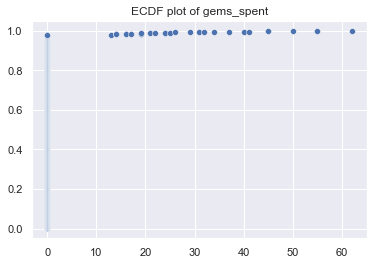

In [28]:
label0_spent_gems = spent_gems_rate(label0_users_spending_ft)
label0_spent_gems = pd.merge(label0_users_df[["user_id"]].drop_duplicates(),\
                                    label0_spent_gems, how='left', on ="user_id").fillna(0)
plot_ecdf(label0_spent_gems["gems_spent"], "ECDF plot of gems_spent")

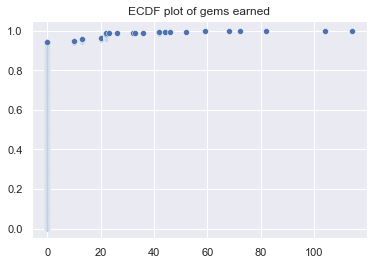

In [29]:
label0_earn_gems = earn_gems_rate(label0_users_spending_ft)
label0_earn_gems = pd.merge(label0_users_df[["user_id"]].drop_duplicates(),\
                                    label0_earn_gems, how='left', on ="user_id").fillna(0)
plot_ecdf(label0_earn_gems["gems_earn"], "ECDF plot of gems earned")

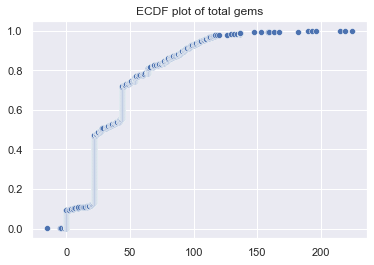

In [30]:
label0_total_gems = total_gems_left(label0_users_spending[label0_users_spending.ts < label0_users_spending.last_active_date])
label0_total_gems = pd.merge(label0_users_df[["user_id"]].drop_duplicates(),\
                                    label0_total_gems, how='left', on ="user_id").fillna(0)
plot_ecdf(label0_total_gems["total_gems"], "ECDF plot of total gems")

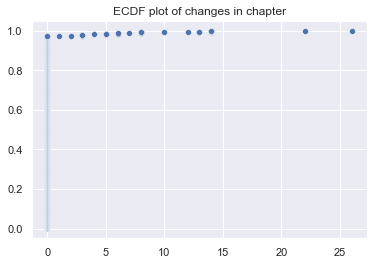

In [31]:
label0_chapter_change = change_in_chapter(label0_users_spending_ft) 
label0_chapter_change = pd.merge(label0_users_df[["user_id"]].drop_duplicates(),\
                                    label0_chapter_change, how='left', on ="user_id").fillna(0)
plot_ecdf(label0_chapter_change["chapter_changes"], "ECDF plot of changes in chapter")

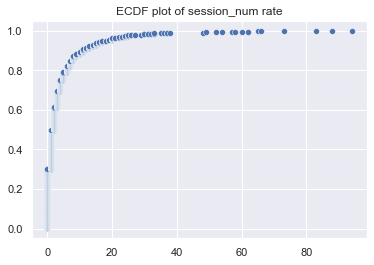

In [32]:
label0_session_change = sessions_num_rate(label0_users_sessions_ft)   
label0_session_change = pd.merge(label0_users_df[["user_id"]].drop_duplicates(),\
                                    label0_session_change, how='left', on ="user_id").fillna(0)
plot_ecdf(label0_session_change["changes_session"], "ECDF plot of session_num rate")

## 4. Extract label 1 class and their characteristics
- Users who already made their first in-app purchase within 45 days since the date they installed in the app 
- A user makes an in-app purchase, but that purchase is not recorded in the spendevent.csv (51 users have this issue, i.e spendevents file faliled to record iap and gems flow for 51 paying users). 

In [103]:
label1_users = first_iap_day_df[first_iap_day_df.days_to_first_purchase >= 7][["user_id", "iap_date"]].drop_duplicates()
label1_users["user_id"].nunique()

239

In [104]:
label1_users.head()

,user_id,iap_date
20,85,2019-04-17 18:26:44
21,93,2019-03-19 07:26:39
24,98,2019-03-11 12:33:16
60,185,2019-03-31 12:58:19
84,247,2019-04-01 11:42:20


### Extracting features for label 1 group

In [105]:
df1 = pd.merge(label1_users, sessions_df, on="user_id")
df1["n_days_before_iap"] = pd.to_datetime(df1["iap_date"]) - pd.Timedelta(days=7)
df_session_ft = df1[(df1.ts > df1.n_days_before_iap) & (df1.ts < df1.iap_date)]
df_session_ft.head(2)

,user_id,iap_date,ts,date,session_num,last_session_termination_type,install_date,days_from_installed,active_days_sessions,last_active_date,n_days_before_iap
12,85,2019-04-17 18:26:44,2019-04-17 18:09:05,2019-04-17,13,NaN,2019-03-07,41,41,2019-04-17 18:09:05,2019-04-10 18:26:44
22,93,2019-03-19 07:26:39,2019-03-19 07:26:34,2019-03-19,11,NaN,2019-03-03,16,60,2019-05-02 16:34:34,2019-03-12 07:26:39


In [106]:
df2 = pd.merge(label1_users, spending_df, on="user_id")
df2["n_days_before_iap"] = pd.to_datetime(df2["iap_date"]) - pd.Timedelta(days=7)
df_spend_ft = df2[(df2.ts > df2.n_days_before_iap) & (df2.ts < df2.iap_date)]
df_spend_ft = df_spend_ft[df_spend_ft.spendtype != "IAP"]
df_spend_ft = df_spend_ft[df_spend_ft.spendtype != "valuepack"]
df_spend_ft.head(2)

,user_id,iap_date,ts,date,story,chapter,spendtype,currency,amount,install_date,days_from_installed,active_days_sessions,last_active_date,n_days_before_iap
9,98,2019-03-11 12:33:16,2019-03-08 15:17:47,2019-03-08,story_1,9,premiumChoice,gems,25,2019-03-02,6,21,2019-04-11 21:52:49,2019-03-04 12:33:16
15,185,2019-03-31 12:58:19,2019-03-31 12:53:13,2019-03-31,story_3,0,earnGemsCounter,gems,0,2019-03-05,26,46,2019-04-20 10:44:38,2019-03-24 12:58:19


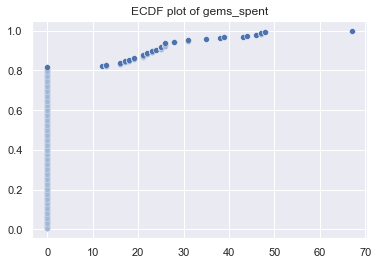

In [107]:
label1_spent_gems = spent_gems_rate(df_spend_ft)
label1_spent_gems = pd.merge(label1_users[["user_id"]].drop_duplicates(),\
                                    label1_spent_gems, how='left', on ="user_id").fillna(0)
plot_ecdf(label1_spent_gems["gems_spent"], "ECDF plot of gems_spent")

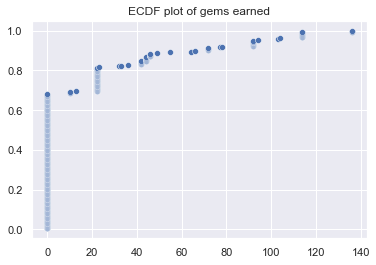

In [108]:
label1_earn_gems = earn_gems_rate(df_spend_ft)
label1_earn_gems = pd.merge(label1_users[["user_id"]].drop_duplicates(),\
                                    label1_earn_gems, how='left', on ="user_id").fillna(0)
plot_ecdf(label1_earn_gems["gems_earn"], "ECDF plot of gems earned")

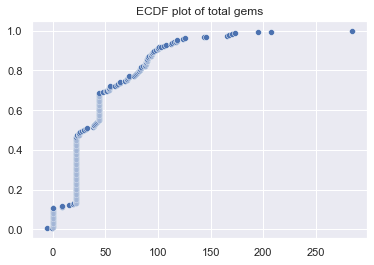

In [109]:
label1_total_gems = total_gems_left(df2[(df2.ts < df2.iap_date)])
label1_total_gems = pd.merge(label1_users[["user_id"]].drop_duplicates(),\
                                    label1_total_gems, how='left', on ="user_id").fillna(0)
plot_ecdf(label1_total_gems["total_gems"], "ECDF plot of total gems")

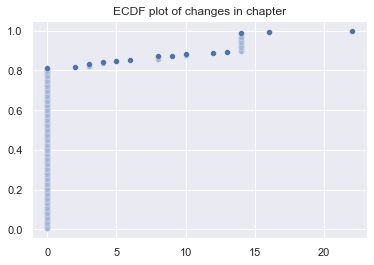

In [110]:
label1_chapter_change = change_in_chapter(df_spend_ft)
label1_chapter_change = pd.merge(label1_users[["user_id"]].drop_duplicates(),\
                                    label1_chapter_change, how='left', on ="user_id").fillna(0)
plot_ecdf(label1_chapter_change["chapter_changes"], "ECDF plot of changes in chapter")

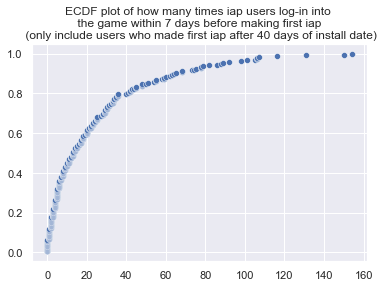

In [111]:
label1_session_change = sessions_num_rate(df_session_ft)    
label1_session_change = pd.merge(label1_users[["user_id"]].drop_duplicates(),\
                                    label1_session_change, how='left', on ="user_id").fillna(0)
plot_ecdf(label1_session_change["changes_session"], "ECDF plot of how many times iap users log-in into \n the game within 7 days before making first iap \n (only include users who made first iap after 40 days of install date)")

## 5.  Feature Engineering 

In [112]:
def feature_engineering_spend(users, df_spend, df_session, ls_ft):
    df_session["ts"] = pd.to_datetime(df_session["ts"])
    df_session["days_of_week"] = df_session["ts"].dt.dayofweek
    df_session["holder"] = 1
    label0_date = pd.pivot_table(df_session, values ="holder", index="user_id", \
                         columns='days_of_week', aggfunc='count').fillna(0).reset_index(col_level=0)
    df_story = df_spend.groupby('user_id')['story'].nunique().reset_index()
    df_chapter = df_spend.groupby('user_id')['chapter'].nunique().reset_index()
    df_days = df_spend.groupby('user_id')['days_from_installed'].max().reset_index()
    
    ls_ft.extend([df_story, df_chapter, df_days, label0_date]) 
    label_fts = users
    for data in ls_ft:
        label_fts = pd.merge(label_fts, data, how = 'left', on="user_id").fillna(0)
    
    return label_fts

In [113]:
promo_group_dfs = [potentialUser_spent_gems,
                potentialUser_earn_gems,
                potentialUser_total_gems,
                potentialUser_chapter_change,
                potentialUser_session_change
                ]         
test_data_fts = feature_engineering_spend(NPU_active_users[["user_id"]],\
                                          NPU_active_users_spending_ft, NPU_active_users_sessions_ft, promo_group_dfs)

C:\Users\NghiTram\anaconda3\envs\kaggleEnv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\NghiTram\anaconda3\envs\kaggleEnv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\NghiTram\anaconda3\envs\kaggleEnv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [114]:
label0_dfs = [label0_spent_gems,
            label0_earn_gems,
            label0_total_gems,
            label0_chapter_change,
            label0_session_change
            ]   
label0_fts = feature_engineering_spend(label0_users_df[["user_id"]], \
                                       label0_users_spending_ft, label0_users_sessions_ft, label0_dfs)

C:\Users\NghiTram\anaconda3\envs\kaggleEnv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\NghiTram\anaconda3\envs\kaggleEnv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\NghiTram\anaconda3\envs\kaggleEnv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [115]:
label1_dfs = [label1_spent_gems,
            label1_earn_gems,
            label1_total_gems,
            label1_chapter_change,
            label1_session_change
            ]  
label1_fts = feature_engineering_spend(label1_users[["user_id"]], \
                                       df_spend_ft, df_session_ft, label1_dfs)

C:\Users\NghiTram\anaconda3\envs\kaggleEnv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\NghiTram\anaconda3\envs\kaggleEnv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\NghiTram\anaconda3\envs\kaggleEnv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a 

In [116]:
label1_fts["label"] = 1
label0_fts["label"] = 0

In [117]:
### calculate class weight
label0_fts.shape[0]/label1_fts.shape[0]

6.351464435146443

In [118]:
df_data = pd.concat([label0_fts, label1_fts])
df_data = df_data.sample(frac=1)
df_data.head(5)

,user_id,gems_spent,gems_earn,total_gems,chapter_changes,changes_session,story,chapter,days_from_installed,0,1,2,3,4,5,6,label
593,8533,0.0,0.0,22.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0
15,1056,22.0,22.0,44.0,8.0,58.0,2.0,2.0,43.0,9.0,0.0,7.0,8.0,8.0,19.0,8.0,1
1052,15713,0.0,0.0,22.0,0.0,2.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0
1313,19727,0.0,0.0,50.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
1064,15949,0.0,0.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


In [119]:
def evaluation(y_true, y_pred, title = ""):
    """
    This function is used to compute the confusion matrix 
    and other evaluation metrics.
    """
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix for {}: \n'.format(title), cm)
    total = sum(sum(cm))
    
    print('=============')
    accuracy = (cm[0,0] + cm[1,1]) /total
    print ('Accuracy    : {}'.format(accuracy))
    Specificity = cm[0,0] / (cm[0,0] + cm[0,1])
    print('Specificity :  {}'.format(Specificity))
    sensitivity = cm[1,1] / (cm[1,0] + cm[1,1])
    print('Sensitivity :  {}'.format(sensitivity))

In [120]:
### preparing data
X = np.array(df_data.loc[:,~df_data.columns.isin(["label", "user_id"])])
y = np.array(df_data["label"])

### spliting test and train dataset from lot 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### fit the model
clf = LogisticRegression(random_state=0, class_weight={0:1, 1:7}).fit(X_train, y_train)

C:\Users\NghiTram\anaconda3\envs\kaggleEnv\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [91]:
evaluation(y_test, clf.predict(X_test))

Confusion Matrix for : 
 [[144   8]
 [  9  15]]
Accuracy    : 0.9034090909090909
Specificity :  0.9473684210526315
Sensitivity :  0.625


In [92]:
clf.predict(np.array(test_data_fts.loc[:,~test_data_fts.columns.isin(["label", "user_id"])])) ### test on potential users

array([0, 1, 0, ..., 0, 0, 1], dtype=int64)

### Potential group 

In [53]:
potential_users_for_promotion = test_data_fts[(test_data_fts.changes_session > 15)\
              & (test_data_fts.changes_session < 50)]
potential_users_for_promotion.shape

(309, 16)

In [54]:
clf.predict_proba(np.array(test_data_fts.loc[:,~test_data_fts.columns.isin(["label", "user_id"])]))

array([[0.92350377, 0.07649623],
       [0.55440588, 0.44559412],
       [0.88829504, 0.11170496],
       ...,
       [0.91385049, 0.08614951],
       [0.9034045 , 0.0965955 ],
       [0.71778615, 0.28221385]])